## KNN (Vecino mas cercano)

Es un metodo de aprendizaje supervisado cuya funcionalidad es buscar en los datos mas cercanos de la que se esta trantando predecir y luego clasificarla basado en los datos que la rodean

En este notebook vamos a entrenar un modelo KNN

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt

from preprocessing import cargarDatasets
from preprocessing import prepararSet
from preprocessing import ingenieriaDeFeaturesVariablesNormalizadas
from preprocessing import ingenieriaDeFeauturesVariablesNormalizadasME

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

## Carga y preprosesamiento de datos

In [2]:
train_df,final_df = cargarDatasets()
train_df = prepararSet(train_df)

ahora que ya tenemos los datasets cargados vamos a ir aplicacion preprocesamientos al dateset de entrenamiento.

In [3]:
X,y,df,y_encoder = ingenieriaDeFeaturesVariablesNormalizadas(train_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y)

In [4]:
X2,y2,df2,y_encoder2, meanEncoding = ingenieriaDeFeauturesVariablesNormalizadasME(train_df)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=117, test_size=0.1, stratify=y2)

Para la busqueda de hiperametros tenemos en cuenta:
   *  k: la cantidad de vecinos que se va a tener en una instancia.
   *  peso: lo que se le da a la distancia entre los puntos.
   *  metrica    

In [5]:
def hallarMejoresHiperparametros(Xtrain, ytrain, Xtest, ytest):
    mejor_puntaje = 0
    mejor_k = -1
    mejor_distancia = None
    mejor_metrica = None
    for tipo_distancias in ['uniform', 'distance']:
        for metrica in ['minkowski','cosine','manhattan','euclidean']:
            for k in range(1, 30):
                knn = KNeighborsClassifier(n_neighbors = k,  weights=tipo_distancias, metric = metrica)
                knn.fit(Xtrain, ytrain)
                puntaje = knn.score(Xtest, ytest)

                if puntaje > mejor_puntaje:
                    mejor_k = k
                    mejor_puntaje = puntaje
                    mejor_distancia = tipo_distancias
                    mejor_metrica = metrica
    print(" mejor puntaje: ", mejor_puntaje)
    print(" mejor k: ", mejor_k)
    print("mejor distancia: ", mejor_distancia)
    print("mejor metrica: ", mejor_metrica)
    return mejor_puntaje, mejor_k, mejor_distancia, mejor_metrica

    

primer preprocesamiento

In [6]:
mejor_valor, mejor_k, mejor_distancia, mejor_metrica = hallarMejoresHiperparametros(X_train, y_train, X_test, y_test)

 mejor puntaje:  0.8434141848326681
 mejor k:  19
mejor distancia:  distance
mejor metrica:  minkowski


segundo preprocesamiento 

In [7]:
mejor_valor2, mejor_k2, mejor_distancia2, mejor_metrica2 = hallarMejoresHiperparametros(X_train2, y_train2, X_test2, y_test2)

 mejor puntaje:  0.8489407430150445
 mejor k:  21
mejor distancia:  distance
mejor metrica:  minkowski


dio mejor el segundo preprocesamiento, vamos a utilizar este para plantear el modelo final 

# Modelo KNN Final
una vez hallados los hiperparametros, vamos a entrenar un modelo definitivo con estos mismo. 

In [8]:
knn = KNeighborsClassifier(n_neighbors = 21, weights = 'distance', metric = 'minkowski')
knn.fit(X_train2, y_train2)

KNeighborsClassifier(n_neighbors=21, weights='distance')

## Analisis de Metricas

In [9]:
y_pred = knn.predict(X_test2)

# Precision, Recall, Acurracy

In [10]:
print(classification_report(y_test, y_pred, target_names=['tiene bajo poder adqusitivo','tiene alto poder adquisitivo']))

                              precision    recall  f1-score   support

 tiene bajo poder adqusitivo       0.88      0.93      0.90      2473
tiene alto poder adquisitivo       0.72      0.60      0.66       784

                    accuracy                           0.85      3257
                   macro avg       0.80      0.77      0.78      3257
                weighted avg       0.84      0.85      0.84      3257



# Accurary 

In [11]:
accuracy_score(y_test, y_pred) 

0.8489407430150445

# Precision 

In [12]:
precision_score(y_test, y_pred)

0.7225609756097561

# Recall

In [13]:
recall_score(y_test, y_pred)

0.6045918367346939

# Matriz de confucion 

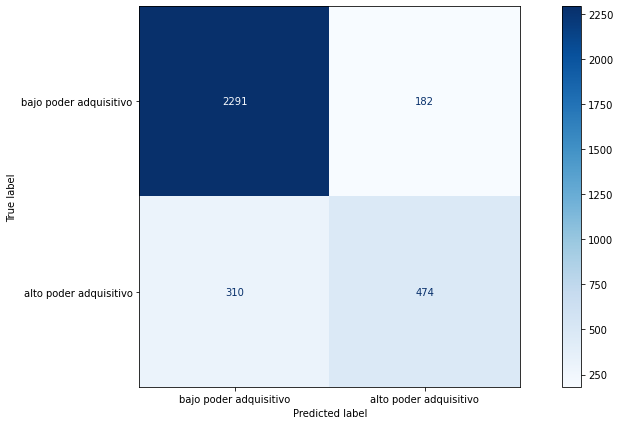

In [14]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
plot_confusion_matrix(
    knn, X_test2, y_test2, cmap=plt.cm.Blues, display_labels=['bajo poder adquisitivo', 'alto poder adquisitivo'], ax=ax
)
plt.show()

# Curva AUC ROC

In [15]:
from sklearn.metrics import roc_curve, auc, plot_roc_curve
from sklearn.metrics import roc_auc_score

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test2)[:,1])

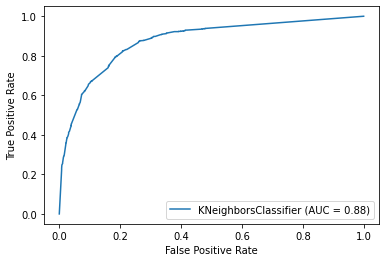

In [17]:
plot_roc_curve(knn,X_test2,y_test2,response_method='predict_proba')
plt.show()

## Prediccion sobre el data set de hold out

In [18]:
from preprocessing import prepararSetDeHoldOutKNN

In [19]:
final_df_copy = prepararSet(final_df)

In [20]:
final_df_copy = prepararSetDeHoldOutKNN(final_df_copy, meanEncoding)

In [21]:
ho_prediction = knn.predict(final_df_copy)
final_df['tiene_alto_valor_adquisitivo'] = ho_prediction

final_df.to_csv('predicciones/knn.csv')